In [171]:
#import modules needed to handle data and encoding
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from openpyxl import load_workbook

class Model:
    def __init__(self, datafile, target):
        #inicialization class object, and also creating the target dataset
        self.df = pd.read_csv(datafile)
        self.y=self.df[target]
        encoder = LabelEncoder()
        encoder.fit(self.y)
        new_data = encoder.transform(self.y)
        new_data.reshape(-1,1)
        self.y=new_data
            
    
    #create data frame with features, drop columns which are unnecessary or are target
    def create_X(self, column):
        self.X = self.df.drop(columns=column)
    
    #function which normalize categories number; for more than 4 categories in one column 
    #it calculates percentage value and for less than 5.5% category name is replaced with 'other'
    def categories_normalization(self):
        for column in self.X.columns:
            if self.X[column].nunique()>4:
                cat = self.X[column].unique()
                number_for_cat = self.X[column].value_counts()
                data_len = len(self.X[column])
                list_to_replace = []
                for i in range(len(cat)):
                    cat_in_perc = round(number_for_cat[i]/data_len*100, 2)
                    if cat_in_perc <= 5.5:
                        list_to_replace.append(cat[i])
                    else:
                        pass
                self.X[column].replace(to_replace=list_to_replace, value='other', inplace=True)
            else:
                pass

    #function which takes data frame, column name and scaler name and return data frame 
    #with encoded column using specified scaler        
    def data_scaler(self, column_header, scaler_name):
        column = np.array(self.X[column_header]).reshape(-1,1)
        scaler = scaler_name()
        scaler.fit(column)
        new_data = scaler.transform(column)
        self.X[column_header + "_scal"] = pd.Series(new_data[:,0])
        self.X.drop(columns=column_header, inplace=True)
    
    #function which takes data frame, column name and encoder name and return data frame 
    #with encoded column using specified encoder
    def data_encoder(self, encoding_function_name):
        for column in self.X.columns:
            if encoding_function_name==OneHotEncoder:
                column_ = np.array(self.X[column]).reshape(-1,1)
                encoder = encoding_function_name(sparse=False)
                encoder.fit(column_)
                categories = encoder.categories_
                new_data = encoder.transform(column_)
                for i in range(len(categories[0])):
                    self.X[column + "_" + categories[0][i]] = pd.Series(new_data[:,i])
                self.X.drop(columns=column, inplace=True)
            elif encoding_function_name==LabelEncoder:
                column_ = self.X[column]
                encoder = encoding_function_name()
                encoder.fit(column_)
                new_data = encoder.transform(column_)
                new_data.reshape(-1,1)
                self.X[column + "_enc"] = pd.Series(new_data)
                self.X.drop(columns=column, inplace=True)
            elif encoding_function_name==OrdinalEncoder:
                column_ = np.array(self.X[column]).reshape(-1,1)
                encoder = encoding_function_name()
                encoder.fit(column_)
                new_data = encoder.transform(column_)
                self.X[column + "_enc"] = pd.Series(new_data[:,0])
                self.X.drop(columns=column, inplace=True)
            else:
                print("Encoder is not specified in function")
    

    #function for chossing type of model and inicialization of model
    def choose_model(self, model_type=None, params={}): #params dict with key, values, we trust user to use proper
        if model_type=='rf':
            self.user_defined_model = RandomForestClassifier(**params)
        elif model_type=='lg':
            self.user_defined_model = LogisticRegression(**params)
        elif model_type=='svc':
            self.user_defined_model = SVC(kernel='rbf', **params)
        elif model_type=='dt':
            self.user_defined_model = DecisionTreeClassifier(**params)
        elif model_type=='knn':
            self.user_defined_model = KNeighborsClassifier(**params)
        else:
            self.user_defined_model = RandomForestClassifier(**params)
    

    #function which split the target and features into test and training datasets, as inputs it get target, features and test_size
    def split(self, test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size, random_state = 42, shuffle=True)

    #function for training model, which takes the training datasets
    def fit(self):
        self.model = self.user_defined_model.fit(self.X_train, self.y_train)
        
    
    #function for predictions, takes the test datasets
    def predict(self):
        self.result = self.model.predict(self.X_test)

    #function which allows identifying best parameters for specified model
    def grid_search_best(self, params={}):
        grid_search = GridSearchCV(self.user_defined_model, param_grid=params, cv=5, verbose=1)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_params_
    
    #function which added the rest function used for modeling, fit, predict and score - run one function instead of 3
    def run_model(self):
        self.fit()
        self.predict()
        self.score()
    
    #checking score of chosen model for test data
    def score(self):
        m_score_train= self.model.score(self.X_train,self.y_train)
        m_score_test = self.model.score(self.X_test, self.y_test)
        f1_score_train = f1_score(self.y_train,self.model.predict(self.X_train))
        f1_score_test = f1_score(self.y_test,self.model.predict(self.X_test))
        return print( f"Accuracy score for train set is {m_score_train}\nAccuracy score for test set is {m_score_test}\nF1 score for train set is {f1_score_train}\nF1 score for test set is {f1_score_test}\n")  

    #function for confusion matrix and  classification report
    def matrix(self):
        conf_matrix=confusion_matrix(self.y_test,self.result)
        class_report=classification_report(self.y_test,self.result)
        sns.heatmap(confusion_matrix(self.y_test, self.result), annot = True)
        return print(f"Confusion matrix: \n {conf_matrix} \nClassification report: \n{class_report}")
    
    #function which allows saving parameters and model information to external file
    def save_model(self, header=False):
        model_name = self.user_defined_model
        model_params = self.model.get_params()
        model_acc_scores = (self.model.score(self.X_train,self.y_train), self.model.score(self.X_test,self.y_test))
        model_f1_scores = (f1_score(self.y_train,self.model.predict(self.X_train)), f1_score(self.y_test,self.model.predict(self.X_test)))
        results = pd.DataFrame({'model': [model_name], 'model_params': [model_params], 'accuracy':[model_acc_scores],'f1':[model_f1_scores]})
        return results.to_csv("model_results.csv", mode='a', index=False, header=header)


Accuracy score for train set is 0.9787659639944607
Accuracy score for test set is 0.9667692307692307
F1 score for train set is 0.9776554404145078
F1 score for test set is 0.9648437500000001

Confusion matrix: 
 [[830  13]
 [ 41 741]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       843
           1       0.98      0.95      0.96       782

    accuracy                           0.97      1625
   macro avg       0.97      0.97      0.97      1625
weighted avg       0.97      0.97      0.97      1625



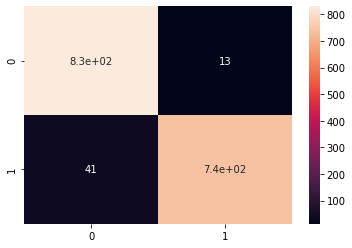

In [172]:
#Random forest model
model_rf=Model("mushrooms.csv","class")
model_rf.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor", "population"])
model_rf.categories_normalization()
model_rf.data_encoder(OneHotEncoder)
model_rf.choose_model('rf')
model_rf.split(0.2)
model_rf.run_model()
model_rf.matrix()

In [103]:
model_rf.grid_search_best(params={"max_depth": [3, 10, 12],
               "n_estimators":[10, 50, 100],
               "min_samples_leaf":[1, 2, 25],
               "max_features":[2, 4, 'auto']})

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  2.2min finished


{'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [173]:
model_rf.save_model(header=True)

Accuracy score for train set is 0.8837495603236019
Accuracy score for test set is 0.8748974569319115
F1 score for train set is 0.8746919431279621
F1 score for test set is 0.8647450110864745

Confusion matrix: 
 [[1158   99]
 [ 206  975]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1257
           1       0.91      0.83      0.86      1181

    accuracy                           0.87      2438
   macro avg       0.88      0.87      0.87      2438
weighted avg       0.88      0.87      0.87      2438



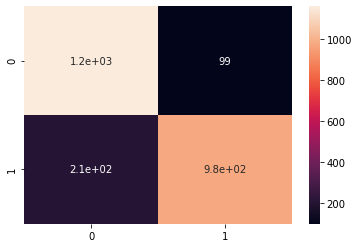

In [174]:
#Logistic regression model
model_lr=Model("mushrooms.csv","class")
model_lr.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor", "population"])
model_lr.categories_normalization()
model_lr.data_encoder(OneHotEncoder)
model_lr.choose_model('lg', params={'C': 0.03})
model_lr.split(0.3)
model_lr.run_model()
model_lr.matrix()

In [175]:
model_lr.save_model()

Accuracy score for train set is 0.8709110094970102
Accuracy score for test set is 0.8638228055783429
Confuction matrix: 
 [[1154  103]
 [ 229  952]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1257
           1       0.90      0.81      0.85      1181

    accuracy                           0.86      2438
   macro avg       0.87      0.86      0.86      2438
weighted avg       0.87      0.86      0.86      2438



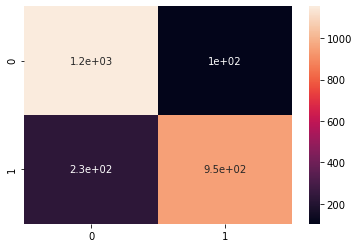

In [19]:
#SVC rbf model
model_svc=Model("mushrooms.csv","class")
model_svc.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor"])
model_svc.categories_normalization()
model_svc.data_encoder(OneHotEncoder)
model_svc.choose_model('svc', params={'C': 0.01})
model_svc.split(0.3)
model_svc.run_model()
model_svc.matrix()

Accuracy score for train set is 0.9785437917692579
Accuracy score for test set is 0.9671862182116489
Confuction matrix: 
 [[1214   43]
 [  37 1144]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1257
           1       0.96      0.97      0.97      1181

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



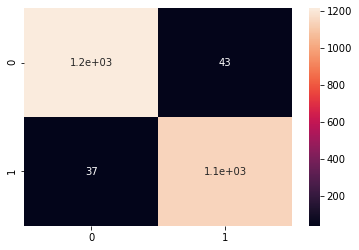

In [22]:
#KNN  model
model_knn=Model("mushrooms.csv","class")
model_knn.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor"])
model_knn.categories_normalization()
model_knn.data_encoder(OneHotEncoder)
model_knn.choose_model('knn')
model_knn.split(0.3)
model_knn.run_model()
model_knn.matrix()

Accuracy score for train set is 0.9843475202251143
Accuracy score for test set is 0.9708777686628384
Confuction matrix: 
 [[1241   16]
 [  55 1126]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1257
           1       0.99      0.95      0.97      1181

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



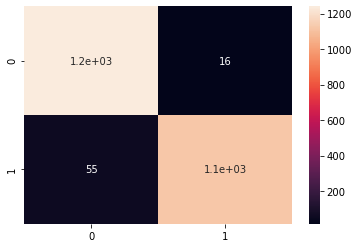

In [23]:
#Decision Tree  model
model_dt=Model("mushrooms.csv","class")
model_dt.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor"])
model_dt.categories_normalization()
model_dt.data_encoder(OneHotEncoder)
model_dt.choose_model('dt')
model_dt.split(0.3)
model_dt.run_model()
model_dt.matrix()